# Installation and neccessary imports

In [1]:
!pip install torch
!pip install torchvision
!pip install Pillow
!pip install -U -q PyDrive
!pip install pretrainedmodels

    100% |████████████████████████████████| 519.5MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5a030000 @  0x7f9888d9c2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 5.2MB/s 
    100% |████████████████████████████████| 2.0MB 12.3MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 61kB 5.4MB/s 
  Running setup.py bdist_wheel for pretrainedmodels ... - \ done
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Running setup.py bdist_wheel for munch ... - done
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e7

In [0]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
from zipfile import ZipFile
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import torchvision
import torchvision.transforms.functional as TF
import random
%matplotlib inline
from IPython import display
import pretrainedmodels

In [0]:
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
    for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## List the files present in the drive and download the dataset

In [4]:
listed = drive.ListFile().GetList()
for file in listed[:10]:
    print('title {}, id {}'.format(file['title'], file['id']))

title KaggleOverfitedTGS.ipynb, id 1Z6SJCxTF5PjBxxWtgOQL9eZUCusnatyu
title North Kolkata Class Schedule, id 1yk7ky5KkQUe4av7IfPK4_8nlFsEYwcaC9gaxyB_aJnM
title raw.zip, id 1MwjE6MUY4OnkTytUMTZKa9WskD43_-Al
title Untitled, id 1QeyytxboPNzYKF1gMY_2dxW1H1HyzCYX
title TGSUNetLinDrpout_epoch66.pt, id 18hmZfahWtQlk3N9FFumsgZXurrkhuKNc
title TGSUNetLinDrpout_epoch61.pt, id 1X9dffcBKTkUDBBviU3qqV8kCQhPWwIk2
title unet_65(2)(2)(4).ipynb, id 12qrSC4GZWTNRCyESDhTCwwvdoBU7mYTl
title submissions_unet_72.csv, id 13AjwjmuQUInx6MldiOiFeEVAkspDRDAN
title TGSUNetLinDrpout_epoch56.pt, id 17E9nWablWBUOVsbPflamN_QljW2OtZ1M
title TGSUNetLinDrpout_epoch51.pt, id 1HkX_GzJnuDfqPyVRKFhs8Z1o2g5hmujX


In [0]:
downloaded = drive.CreateFile({'id': '1MwjE6MUY4OnkTytUMTZKa9WskD43_-Al'})
downloaded.GetContentFile('train.zip')
with ZipFile("train.zip", 'r') as z:
    z.extractall()
os.remove("train.zip")

In [6]:
os.listdir()

['sample_data', '.config', 'train.csv', 'train', 'depths.csv', 'adc.json']

## Some utility functions

In [0]:
def normalize(df,cols,dtype = 'float16'):
    data = df
    for col in cols:
        data[col] = ((data[col]-data[col].mean())/(data[col].max()-data[col].min())).astype(dtype)
    return data
def display_tensor(x):
    if type(x) is tuple:
        img,msk = x
        fig, axes = plt.subplots(ncols=2,nrows=1)
        axes.ravel()[0].imshow(img[0,:,:].cpu().numpy(),cmap='gray')
        axes.ravel()[0].set_title('Image')
        axes.ravel()[1].imshow(msk[0,:,:].numpy(),cmap='gray')
        axes.ravel()[1].set_title('Mask')
        plt.show()
    else:
        plt.imshow(x[0,:,:].cpu().numpy(),cmap='gray')
def adjust_learning_rate(optimizerr,lr):
    for param_group in optimizerr.param_groups:
        param_group['lr'] = lr
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    torch.save(state, filename)
    uploaded = drive.CreateFile({'title': 'MixNetv1_epoch'+str(state['epoch'])+'.pt'})
    uploaded.SetContentFile(filename)
    uploaded.Upload()
def load_checkpoint(args):
     
    if os.path.isfile(args):
        print("=> loading checkpoint '{}'".format(args))
        checkpoint = torch.load(args)
        epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(args, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))
        

# Dataset Class

In [0]:
class TGS_dataset(Dataset):
    '''
    This is the dataset class that feeds the data to the model.
    It has been created with a specific file organization in mind as given below:
    test.csv
    root/
      |---train.csv
      |---depths.csv
      |--train/
      |   |---images/
      |   |       -images...
      |   |---masks/
      |          -masks...
      |--test/
      |   |---images/
      |   |       -images...
      |   |---masks/
      |          -masks...
       
      The transform method can be made more efficient while running on test by checking is_train=False and then skipping over mask
    '''
    def __init__(self,root='./',is_train=True):
        depths = normalize(pd.read_csv(root+'depths.csv'), ['z'])
        if(is_train):
            self.input = pd.read_csv(root+'train.csv').merge(depths, on='id', how='left')
            self.input.drop(['rle_mask'], axis=1, inplace=True)
            self.image_dir = root+'train/images'
            self.mask_dir = root+'train/masks'
        else:
            self.input = pd.read_csv('test.csv').merge(depths, on='id', how='left')
            self.image_dir = root+'test/images'
        self.is_train = is_train
        
    
    def __len__(self):
        return len(self.input)

    
    def transform(self,image,mask,depth):
#         image, mask =  TF.to_grayscale(image), TF.to_grayscale(mask)
        mask = TF.to_grayscale(mask)
        resize = transforms.Resize((128,128))
        image,mask = resize(image), resize(mask)
        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask).view(128,128)

        # append depth data to image
#         d = torch.ones((1)).new_full((1,128,128),depth)
#         image = torch.cat((image,d),0)

        return image, mask
        
            
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir,self.input.iloc[idx,0]+".png")
        img = Image.open(img_name)
        if self.is_train :
            msk = Image.open(os.path.join(self.mask_dir,self.input.iloc[idx,0]+".png"))
        else:
            msk = img
        depth = self.input.iloc[idx,1]
        img,msk = self.transform(img,msk,float(depth))
        if self.is_train: return img,msk
        else : return img

In [0]:
train_dataset = TGS_dataset(is_train = True)

# Model Area

In [0]:
class Down(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Down, self).__init__()
        self.down = nn.Sequential(nn.Conv2d(in_channels,out_channels,(3,3),stride=1, padding=1),
                                 nn.AvgPool2d(kernel_size=(2,2)),
                                 nn.BatchNorm2d(out_channels),
                                  nn.ReLU()
                                 )
    def forward(self,x):
#         print(x.shape)
        return self.down(x)

In [0]:
class Up(nn.Module):
    def __init__(self,in_channels, out_channels,size):
        super(Up,self).__init__()
#         self.upscale = nn.Upsample(scale_factor= 2)
        self.upscale = nn.ConvTranspose2d(in_channels = in_channels, out_channels = out_channels, kernel_size = (2,2),stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.out_channels = out_channels
        self.nonlin1 = nn.ReLU()
        self.nonlin2 = nn.ReLU()
        self.size = size
        self.noe = size ** 2
        
#         self.bilinear = nn.Bilinear(self.noe ,self.noe ,self.noe )
                
    def forward(self,x1, x2):
        x1 = self.upscale(x1)
        x1 = self.bn(x1)
        x1 = self.nonlin1(x1)
#         print(x1.shape)
#         print(x2.shape)
        x = torch.cat((x1, x2),dim=1)
        return x

In [0]:
class Decoder(nn.Module):
    def __init__(self,no_features=2048,in_size=(4,4),out_size=(128,128),in_channels=3):
        super(Decoder,self).__init__()
        self.down1 = Down(in_channels,32)
        self.down2 = Down(32,128)
        self.down3 = Down(128,256)
        self.down4 = Down(256,512)
        
        self.up1 = Up(2048, 512, 8)
        self.up2 = Up(1024, 256, 16)
        self.up3 = Up(512, 128, 32)
        self.up4 = Up(256, 32, 64)
        self.up5 = Up(64,5,128)
        
        
    def forward(self,img,feats):
        x1 = self.down1(img)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        
        x = self.up1(feats, x4)
        x = self.up2(x,x3)
        x = self.up3(x, x2)
        x = self.up4(x,x1)
        x = self.up5(x,img)
        return x

### importing Se Resnext 50 trained on imagenet

In [0]:
class MixNet(nn.Module):
    def __init__(self,in_channels = 3, out_channels=1, base= 'se_resnext50_32x4d'):
        super(MixNet, self).__init__()
        self.resnet = pretrainedmodels.__dict__[base](num_classes=1000, pretrained='imagenet')
        self.decoder = Decoder()
        self.conv1 = nn.Conv3d(1,1,kernel_size=(8,1,1),stride=(8,1,1))
        self.conv2 = nn.Conv2d(1,2,kernel_size=3,padding=1)
       
        
    def forward(self,x):
        feats = self.resnet.features(x)
        x = self.decoder(x,feats)
        x.unsqueeze_(1)
        x = self.conv1(x)
        x.squeeze_(1)
        x = self.conv2(x)
        return F.softmax(x)

In [0]:
batch_size = 50
validation_split = 0.1
shuffle_dataset = True
random_seed= 42
# Creating data indices for training and validation splits:
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,sampler=validation_sampler)

In [0]:
class BinaryCrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True):
        """
        Binary cross entropy loss 2D
        Args:
            weight:
            size_average:
        """
        super(BinaryCrossEntropyLoss2d, self).__init__()
        self.bce_loss = nn.BCELoss(weight, size_average)
        if torch.cuda.is_available():
            self.bce_loss = self.bce_loss.cuda()
        self.threshold = torch.tensor(0.3,requires_grad=True).cuda()

    def forward(self, pred, target):
#         pred = F.sigmoid(pred)
        threshold=0.3
        pred1 = ((pred>(1-self.threshold)) * (pred<(1+self.threshold))).float().cuda()
        pred1 = pred1.view(-1)  # Flatten
        target = target.view(-1)  # Flatten
        return self.bce_loss(pred1, target)

In [0]:
class SoftDiceLoss(nn.Module):
    def __init__(self):
        super(SoftDiceLoss, self).__init__()
    def forward(self, pred, target):
        smooth = 1
        num = target.size(0)
        #pred = F.sigmoid(pred)
        pred = pred.view(num, -1)
        target = target.view(num, -1)
        intersection = (pred * target)
        score = 2. * (intersection.sum(1) + smooth) / (pred.sum(1) + target.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score

In [0]:
def dice_coeff(pred, target):
    smooth = 1.
    num = target.size(0)
    pred = pred.view(num, -1)  # Flatten
    target = target.view(num, -1)  # Flatten
    intersection = (pred * target)
    score = (2. * intersection.sum(1) + smooth).float() / (pred.sum(1) + target.sum(1) + smooth).float()
    return score.sum()/num

In [0]:
def bce_dice_loss(y_true, y_pred):
    return 0.5*BinaryCrossEntropyLoss2d()(y_true, y_pred)-dice_coeff(y_true, y_pred)

In [0]:
model=MixNet().float()
criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
if torch.cuda.is_available():
    model = model.cuda()

In [0]:
def validate():
    total_loss = 0
    total_accuracy = 0
    model.eval()
    for batch_idx, (data,target) in enumerate(validation_loader):
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        target = target.long()
        # forward
        output = model(data)
        predict =torch.argmax(output, dim=1)
        # backward + optimize
        loss = criterion(output, target)
        # print statistics
        accuracy = dice_coeff(predict,target)
        total_accuracy+=accuracy.item()
        total_loss+=loss.item()
    print('Validation Loss: {:.5f} Validation Accuracy: {:.5f}'.format(total_loss*batch_size/len(val_indices),total_accuracy*batch_size/len(val_indices)))
    return total_loss,total_accuracy

In [0]:
def train(epoch=1):
    loss_train_data = []
    accuracy_train_data = []
    loss_test_data = []
    accuracy_test_data = []
    epoch_data=[]
    while True:
        total_loss = 0
        total_accuracy = 0
        model.train()
#         if epoch%5==0:
#             save_checkpoint({
#                 'epoch': epoch + 1,
#                 'state_dict': model.state_dict(),
#                 'optimizer' : optimizer.state_dict(),
#                 })
        exp_lr_scheduler.step()
        print(exp_lr_scheduler.get_lr())
        for batch_idx, data in enumerate(train_loader):
            X,target = data
            target = target.long()
            if torch.cuda.is_available():
                X = X.cuda()
                target = target.cuda()
            # forward
            output = model(X)
            predict =torch.argmax(output, dim=1)
            
            # backward + optimize
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # print statistics
            accuracy = dice_coeff(predict,target)
            total_accuracy+=accuracy.item()
            total_loss+=loss.item()
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.5f}\tAccuracy: {:.5f}'.format(epoch, (batch_idx + 1) * batch_size, len(train_indices),100*(batch_idx + 1)* batch_size / len(train_indices), loss.item(),accuracy))
        print('Train Loss: {:.5f} Train Accuracy: {:.5f}'.format(total_loss*batch_size/len(train_indices),total_accuracy*batch_size/len(train_indices)))
        loss,accuracy = validate()
        # Data append
        loss_train_data.append(total_loss*batch_size/len(train_indices))
        loss_test_data.append(loss*batch_size/len(val_indices))
        accuracy_train_data.append(total_accuracy*batch_size/len(train_indices))
        accuracy_test_data.append(accuracy*batch_size/len(val_indices))
        epoch_data.append(epoch)
        # Visualize
        plt.figure(figsize=(10,5))
#         plt.plot(epoch_data, loss_train_data,label="Train Loss {:.5f}".format(loss_train_data[-1]))
        plt.plot(epoch_data, accuracy_train_data,label="Train Accuracy {:.5f}".format(accuracy_train_data[-1]))
#         plt.plot(epoch_data,loss_test_data, label="Validation Loss {:.5f}".format(loss_test_data[-1]))
        plt.plot(epoch_data,accuracy_test_data,label="Validation Accuracy {:.5f}".format(accuracy_test_data[-1]))
        display.clear_output(wait=False)
        plt.legend()
        plt.show()
        epoch+=1

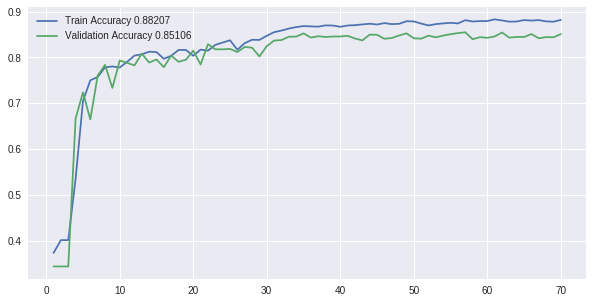

[0.0010000000000000002]
Epoch: 71 [50/3600 (1%)]	Loss: 0.34766	Accuracy: 0.84166
Epoch: 71 [100/3600 (3%)]	Loss: 0.34470	Accuracy: 0.88358
Epoch: 71 [150/3600 (4%)]	Loss: 0.32510	Accuracy: 0.87860
Epoch: 71 [200/3600 (6%)]	Loss: 0.34981	Accuracy: 0.88841
Epoch: 71 [250/3600 (7%)]	Loss: 0.32377	Accuracy: 0.89879
Epoch: 71 [300/3600 (8%)]	Loss: 0.33073	Accuracy: 0.91378
Epoch: 71 [350/3600 (10%)]	Loss: 0.32863	Accuracy: 0.92649


KeyboardInterrupt: ignored

In [23]:
train()

In [22]:
validate()

Validation Loss: 0.67177 Validation Accuracy: 0.34218


(5.37412166595459, 2.7374233305454254)

# Review 
Big improvement over last time(incorect implamentation)
This shall serve as our baseline for future experiments
The model starts to converge with about 0.88 dice score on train and 0.85 on validation
The hyperparameters are very much arbitrary and hence there is lot of scope to improve that
## Remarks
- slight overfitting (expected more because of no dropout but random flips and resnext's features are quite balancing the absence of regularization)

- the final conv2d with padding maybe giving wrong values for boundary pixels that make up (4*127)/2^14 or about 3% 

## Future scope
- lovasz loss

- other pretrained models

